# Allatom models

Parameters:

* $c$ -- cutoff
* $b$ -- number of bins for each pair of atom types
* $r$ -- topological distance to skipping neighbouring atoms

In [1]:
import numpy as np
import scipy
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import seaborn
from multiprocessing import Pool, TimeoutError
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer, normalize, MaxAbsScaler
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.externals import joblib
from sklearn.linear_model import (LogisticRegression, LinearRegression,
                                  BayesianRidge, ElasticNet, Ridge)
%matplotlib inline
%load_ext autoreload
%autoreload 2

from scripts.data_mining import *

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [26]:
mat_file_patterns = []

for cutoff in [5, 6, 7]:
    for num_bins in [7, 10, 15, 20, 25]:
        for radius in [0, 1, 2]:
            mat_file_patterns.append('*allatom-s0-b{}-c{}-r{}--residue_dependent--skip_errors.mat'.format(num_bins, cutoff, radius))

In [3]:
checksums = ['58de9109da959d5b94380e3eaca552c1']

In [4]:
def get_natives(scores):
    natives = np.array([bool(re.match('T0...\.pdb', x.split('/')[-1])) for x in scores.index])
    return pd.Series(data=natives, index=scores.index)

In [5]:
models = [
    ("Normalizer + Logistic",
     Pipeline([('normalizer', Normalizer()),
               ('one_hot_imputer', OneHotImputer()),
               ('model', LogisticRegression(class_weight={False: 1, True: 100}))]),
     lambda lr_clf, X_train, scores_train: lr_clf.fit(X_train, get_natives(scores_train)),
     lambda lr_clf, X: -lr_clf.decision_function(X)),
    ("MaxAbsScaler + Logistic",
     Pipeline([('normalizer', MaxAbsScaler()),
               ('one_hot_imputer', OneHotImputer()),
               ('model', LogisticRegression(class_weight={False: 1, True: 100}))]),
     lambda lr_clf, X_train, scores_train: lr_clf.fit(X_train, get_natives(scores_train)),
     lambda lr_clf, X: -lr_clf.decision_function(X)),
    ("Normalizer + Ridge",
     Pipeline([('normalizer', Normalizer()),
               ('one_hot_imputer', OneHotImputer()),
               ('model', Ridge(fit_intercept=False))]),
     lambda ridge_lm, X_train, scores_train: ridge_lm.fit(X_train, 1 - scores_train['GDT-TS-score']),
     lambda ridge_lm, X: ridge_lm.predict(X)),
    ("MaxAbsScaler + Ridge",
     Pipeline([('normalizer', MaxAbsScaler()),
               ('one_hot_imputer', OneHotImputer()),
               ('model', Ridge(fit_intercept=False))]),
     lambda ridge_lm, X_train, scores_train: ridge_lm.fit(X_train, 1 - scores_train['GDT-TS-score']),
     lambda ridge_lm, X: ridge_lm.predict(X))
]

In [6]:
scores = load_pickled_dataset(dataset_binary_filename(mat_file_patterns[0], checksums[0], 'binaries'))[1]
scores = select_subset(scores, scores, '^.*CASP([5-9]|10)/T..../.*$')[1]
indices = scores.index.sort_values().copy()

In [7]:
results_train = {}
results_val = {}

In [8]:
def compute_results(args):
    try:
        mat_file_pattern, indices = args

        for checksum in checksums:
            try:
                X, scores, _ = load_pickled_dataset(
                    dataset_binary_filename(mat_file_pattern, checksum, 'binaries')
                )
                break
            except:
                X, scores = None, None

        if X is None:
            print(mat_file_pattern, '\tError: Dataset not found', flush=True)
            return mat_file_pattern, None

        scores['__temp_index'] = range(scores.shape[0])
        scores = scores.loc[indices]
        if pd.isnull(scores['__temp_index']).sum():
            print(mat_file_pattern, '\tError: Got smaller dataset', flush=True)
            return mat_file_pattern, None

        X = X[scores['__temp_index'].values]
        del scores['__temp_index']

        old_shape = X.shape
        X, nonzero_features = remove_zero_features(X)
        print(mat_file_pattern, '\tX.size: {},\t{} -> {}'.format(X.size, old_shape, X.shape), flush=True)

        train_blocks, train_idx, val_blocks, val_idx = train_test_split(one_hot_from_scores(scores),
                                                                        test_ratio=0.4, seed=17)
        X_train = X[train_idx]
        X_val = X[val_idx]
        del X
        scores_train = scores[train_idx]
        scores_val = scores[val_idx]

        results_train = {}
        results_val = {}

        for model_name, model, train, predicted_score in models:

            ### Train
            train(model, X_train, scores[train_idx])

            ### Results on training set
            results_train[model_name + ' + native'], _ = scoring_results(X_train, scores_train,
                                                           lambda X: predicted_score(model, X),
                                                           num_plots=0)

            results_train[model_name], _ = scoring_results(X_train[~get_natives(scores_train).values],
                                                           scores_train[~get_natives(scores_train).values],
                                                           lambda X: predicted_score(model, X),
                                                           num_plots=0)
            ### Results on validation set
            results_val[model_name + ' + native'], _ = scoring_results(X_val, scores_val,
                                                         lambda X: predicted_score(model, X),
                                                         num_plots=0)

            results_val[model_name], _ = scoring_results(X_val[~get_natives(scores_val).values],
                                                         scores_val[~get_natives(scores_val).values],
                                                         lambda X: predicted_score(model, X),
                                                         num_plots=0)

        return mat_file_pattern, (results_train, results_val)
    except Exception as e:
        print(mat_file_pattern, '\tError: Exception', e, flush=True)
        return mat_file_pattern, None

In [27]:
pool = Pool(processes=1)
pool_result = pool.imap_unordered(compute_results, [(mat_file_pattern, indices)
                                       for mat_file_pattern in mat_file_patterns
                                       if mat_file_pattern not in results_train.keys()])
pool.close()

In [45]:
returned = []

try:
    while True:
        returned.append(pool_result.next(timeout=0))
except TimeoutError:
    print('Timeout')
except StopIteration:
    print('Done')

for mat_file_pattern, res in returned:
    if res:
        results_train[mat_file_pattern], results_val[mat_file_pattern] = res

len(returned), len([x for x in returned if x[1]])

Timeout


(0, 0)

## Test

In [14]:
params = ['b', 'c', 'r']

In [15]:
def mean_top1_score(scores):
    return scores['GDT-TS-score']['Mean score for top 1']

def correlation_score(scores):
    return -scores['GDT-TS-score'][['Mean Pearson', 'Mean Spearman']].mean()

def summary(results):
    records = []
    for quality_criterion in [mean_top1_score, correlation_score]:
        for model in sorted(list(results.items())[0][1].keys()):
            benchmark = generate_benchmark(results, quality_criterion)
            best_dataset = benchmark[model].argmax()
            records.append((best_dataset,
                            model + ' + ' + quality_criterion.__name__,
                            results[best_dataset][model]['GDT-TS-score']))
    df = pd.concat([x[2] for x in records], axis=1)
    df.columns = [x[1] for x in records]
    df.loc['The best dataset'] = [x[0] for x in records]
    return df

def plot_results(results, model, quality_criterion, params, **kwargs):
    benchmark = generate_benchmark(results, quality_criterion)
    plot_heatmaps(benchmark, model, params, **kwargs)

    print('The best:\n{}'.format(benchmark[model].argmax()))
    display(results[benchmark[model].argmax()][model])

In [46]:
df = summary(results_val)
display(df.iloc[:, [c.split(' + ')[-2] == 'native' for c in df.columns]].T)
display(df.iloc[:, [c.split(' + ')[-2] != 'native' for c in df.columns]].T)

Mean Pearson Mean Spearman  \
MaxAbsScaler + Logistic + native + mean_top1_score    -0.271215     -0.178181   
MaxAbsScaler + Ridge + native + mean_top1_score       -0.356762     -0.277557   
Normalizer + Logistic + native + mean_top1_score      -0.317581     -0.244552   
Normalizer + Ridge + native + mean_top1_score         -0.559549     -0.463903   
MaxAbsScaler + Logistic + native + correlation_...    -0.271763     -0.182461   
MaxAbsScaler + Ridge + native + correlation_score     -0.393194     -0.330708   
Normalizer + Logistic + native + correlation_score    -0.396365     -0.319182   
Normalizer + Ridge + native + correlation_score       -0.578494     -0.480005   

                                                   Mean loss score  \
MaxAbsScaler + Logistic + native + mean_top1_score       0.0838155   
MaxAbsScaler + Ridge + native + mean_top1_score           0.423073   
Normalizer + Logistic + native + mean_top1_score         0.0806469   
Normalizer + Ridge + native + mean_top1_score              0.23337   
MaxAbsScaler + Logistic + native + correlation_...         0.11321   
MaxAbsScaler + Ridge + native + correlation_score         0.432017   
Normalizer + Logistic + native + correlation_score        0.104369   
Normalizer + Ridge + native + correlation_score           0.265338   

                                                   Mean rank of the native  \
MaxAbsScaler + Logistic + native + mean_top1_score                 5.16372   
MaxAbsScaler + Ridge + native + mean_top1_score                     34.792   
Normalizer + Logistic + native + mean_top1_score                   3.99115   
Normalizer + Ridge + native + mean_top1_score                      11.2566   
MaxAbsScaler + Logistic + native + correlation_...                 4.27434   
MaxAbsScaler + Ridge + native + correlation_score                  30.4115   
Normalizer + Logistic + native + correlation_score                  3.5177   
Normalizer + Ridge + native + correlation_score                    11.3274   

                                                   Mean score for top 1  \
MaxAbsScaler + Logistic + native + mean_top1_score             0.916185   
MaxAbsScaler + Ridge + native + mean_top1_score                0.576927   
Normalizer + Logistic + native + mean_top1_score               0.919353   
Normalizer + Ridge + native + mean_top1_score                   0.76663   
MaxAbsScaler + Logistic + native + correlation_...              0.88679   
MaxAbsScaler + Ridge + native + correlation_score              0.567983   
Normalizer + Logistic + native + correlation_score             0.895631   
Normalizer + Ridge + native + correlation_score                0.734662   

                                                        PMCC      SMCC  \
MaxAbsScaler + Logistic + native + mean_top1_score       NaN       NaN   
MaxAbsScaler + Ridge + native + mean_top1_score          NaN       NaN   
Normalizer + Logistic + native + mean_top1_score         NaN       NaN   
Normalizer + Ridge + native + mean_top1_score            NaN       NaN   
MaxAbsScaler + Logistic + native + correlation_...       NaN       NaN   
MaxAbsScaler + Ridge + native + correlation_score        NaN       NaN   
Normalizer + Logistic + native + correlation_score       NaN       NaN   
Normalizer + Ridge + native + correlation_score    -0.684475 -0.691999   

                                                        Top 1     Top 5  \
MaxAbsScaler + Logistic + native + mean_top1_score   0.823009  0.889381   
MaxAbsScaler + Ridge + native + mean_top1_score      0.132743  0.327434   
Normalizer + Logistic + native + mean_top1_score     0.818584  0.902655   
Normalizer + Ridge + native + mean_top1_score        0.460177  0.659292   
MaxAbsScaler + Logistic + native + correlation_...   0.774336  0.867257   
MaxAbsScaler + Ridge + native + correlation_score   0.0884956   0.30531   
Normalizer + Logistic + native + correlation_score   0.809735  0.915929   
Normalizer + Ridge + native + correlation_sc

Mean Pearson Mean Spearman  \
MaxAbsScaler + Logistic + mean_top1_score      -0.210022     -0.157968   
MaxAbsScaler + Ridge + mean_top1_score          -0.36459     -0.315245   
Normalizer + Logistic + mean_top1_score        -0.337418     -0.291707   
Normalizer + Ridge + mean_top1_score           -0.564683     -0.474366   
MaxAbsScaler + Logistic + correlation_score    -0.226279     -0.173946   
MaxAbsScaler + Ridge + correlation_score       -0.375566     -0.325332   
Normalizer + Logistic + correlation_score      -0.364118     -0.311912   
Normalizer + Ridge + correlation_score         -0.565388     -0.475094   

                                            Mean loss score  \
MaxAbsScaler + Logistic + mean_top1_score          0.149845   
MaxAbsScaler + Ridge + mean_top1_score             0.130674   
Normalizer + Logistic + mean_top1_score            0.136273   
Normalizer + Ridge + mean_top1_score               0.128007   
MaxAbsScaler + Logistic + correlation_score        0.167691   
MaxAbsScaler + Ridge + correlation_score           0.131883   
Normalizer + Logistic + correlation_score          0.142451   
Normalizer + Ridge + correlation_score             0.131792   

                                            Mean rank of the native  \
MaxAbsScaler + Logistic + mean_top1_score                   111.044   
MaxAbsScaler + Ridge + mean_top1_score                      94.9469   
Normalizer + Logistic + mean_top1_score                     81.5664   
Normalizer + Ridge + mean_top1_score                        76.2965   
MaxAbsScaler + Logistic + correlation_score                 107.637   
MaxAbsScaler + Ridge + correlation_score                    94.5442   
Normalizer + Logistic + correlation_score                   81.0044   
Normalizer + Ridge + correlation_score                       76.177   

                                            Mean score for top 1      PMCC  \
MaxAbsScaler + Logistic + mean_top1_score               0.490332       NaN   
MaxAbsScaler + Ridge + mean_top1_score                  0.509503       NaN   
Normalizer + Logistic + mean_top1_score                 0.503904       NaN   
Normalizer + Ridge + mean_top1_score                     0.51217 -0.681959   
MaxAbsScaler + Logistic + correlation_score             0.472486       NaN   
MaxAbsScaler + Ridge + correlation_score                0.508294       NaN   
Normalizer + Logistic + correlation_score               0.497726       NaN   
Normalizer + Ridge + correlation_score                  0.508385 -0.682042   

                                                 SMCC       Top 1      Top 5  \
MaxAbsScaler + Logistic + mean_top1_score         NaN  0.00884956  0.0486726   
MaxAbsScaler + Ridge + mean_top1_score            NaN  0.00442478  0.0663717   
Normalizer + Logistic + mean_top1_score           NaN   0.0353982   0.079646   
Normalizer + Ridge + mean_top1_score        -0.689779  0.00884956  0.0575221   
MaxAbsScaler + Logistic + correlation_score       NaN  0.00884956  0.0309735   
MaxAbsScaler + Ridge + correlation_score          NaN  0.00884956   0.079646   
Normalizer + Logistic + correlation_score         NaN   0.0309735  0.0840708   
Normalizer + Ridge + correlation_score      -0.690001  0.00884956  0.0530973   

                                            sum Z-score    wmPMCC    wmSMCC  \
MaxAbsScaler + Logistic + mean_top1_score           NaN       NaN       NaN   
MaxAbsScaler + Ridge + mean_top1_score              NaN       NaN       NaN   
Normalizer + Logistic + mean_top1_score             NaN       NaN       NaN   
Normalizer + Ridge + mean_top1_score            86.9808 -0.620627  -0.50115   
MaxAbsScaler + Logistic + correlation_score         NaN       NaN       NaN   
MaxAbsScaler + Ridge + correlation_score            NaN       NaN       NaN   
Normalizer + Logistic + correlation_score           NaN       NaN       NaN   
Normalizer + Ridge + correlation_score          81.0393  -0.62145 -0.501945   

                                 

In [17]:
df2 = generate_benchmark(results_val, lambda scores: scores.ix['Top 1', 'RMSD'])
[p for p in set(df2.columns) - set(list(results_val.items())[0][1].keys()) if len(df2[p].unique()) > 1]

['r', 'c', 'b']

### Classification

#### Row normalization

##### Mean score for top 1

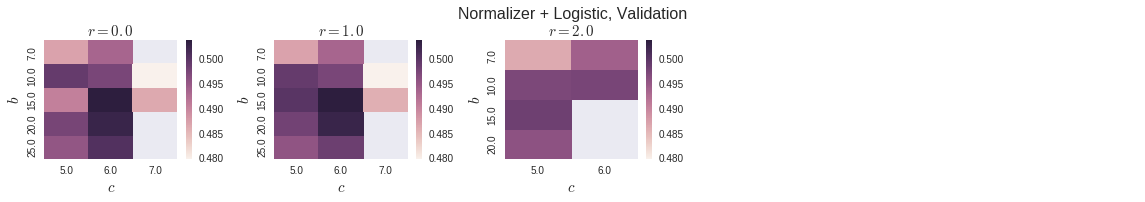

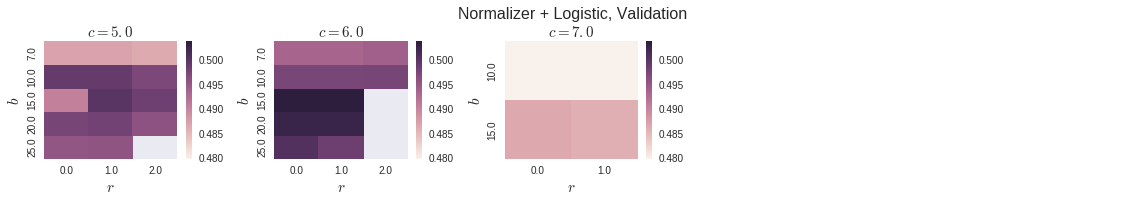

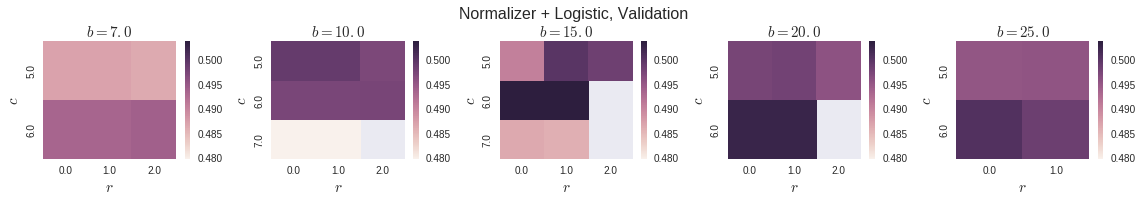

The best:
*allatom-s0-b15-c6-r0--residue_dependent--skip_errors.mat


RMSD   TM-score MaxSub-score GDT-TS-score  \
Mean rank of the native    103.558    95.5929      81.7168      81.5664   
Top 1                    0.0265487  0.0176991    0.0176991    0.0353982   
Top 5                    0.0973451  0.0619469     0.039823     0.079646   
Mean score for top 1       8.15081   0.568121     0.465515     0.503904   
Mean loss score           -5.52421   0.144484     0.143774     0.136273   
Mean Pearson               0.32346  -0.315641    -0.343421    -0.337418   
Mean Spearman             0.313748   -0.26817    -0.297303    -0.291707   

                        GDT-HA-score RMSD-backwards TM-score-backwards  \
Mean rank of the native      82.8717        224.305                 82   
Top 1                      0.0309735              0          0.0309735   
Top 5                      0.0929204              0           0.128319   
Mean score for top 1        0.363627        8.15081           0.589284   
Mean loss score             0.112795        55.6843           0.165025   
Mean Pearson               -0.350566        0.32346          -0.373746   
Mean Spearman              -0.304254       0.313767          -0.351159   

                        MaxSub-score-backwards GDT-TS-score-backwards  \
Mean rank of the native                91.3142                91.1726   
Top 1                                0.0176991              0.0221239   
Top 5                                  0.10177                0.10177   
Mean score for top 1                   0.48793               0.529539   
Mean loss score                       0.244877                0.22931   
Mean Pearson                         -0.371138               -0.37669   
Mean Spearman                        -0.354463              -0.361878   

                        GDT-HA-score-backwards  
Mean rank of the native                89.9602  
Top 1                                0.0265487  
Top 5                                  0.10177  
Mean score for top 1                  0.382161  
Mean loss score                       0.221193  
Mean Pearson                         -0.371953  
Mean Spearman                        -0.356596

In [47]:
plot_results(results_val,
             'Normalizer + Logistic', mean_top1_score,
             params, info='Validation', num_cols=5)

##### Correlation score 

plot_results(results_val,
             'Normalizer + Logistic', correlation_score,
             params, info='Validation', num_cols=5, figsize=1)

#### Feature normalization

##### Mean score for top 1

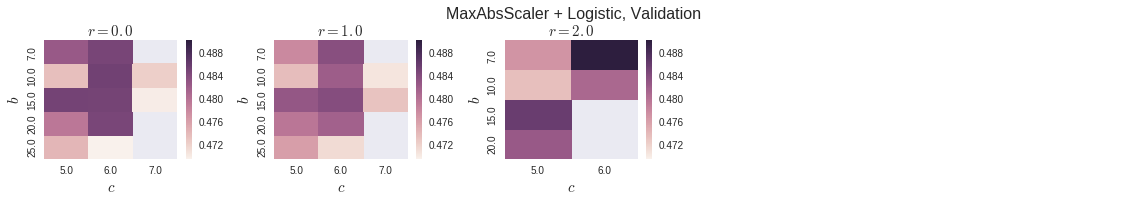

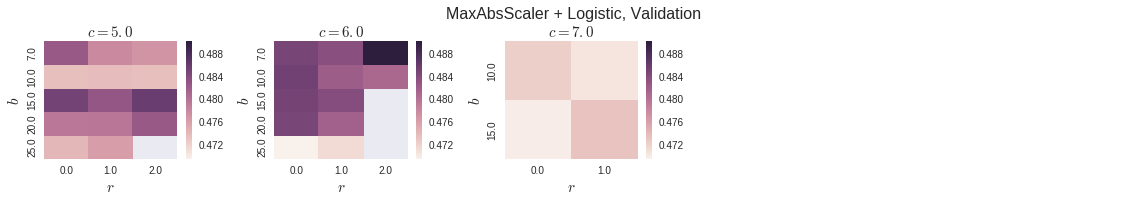

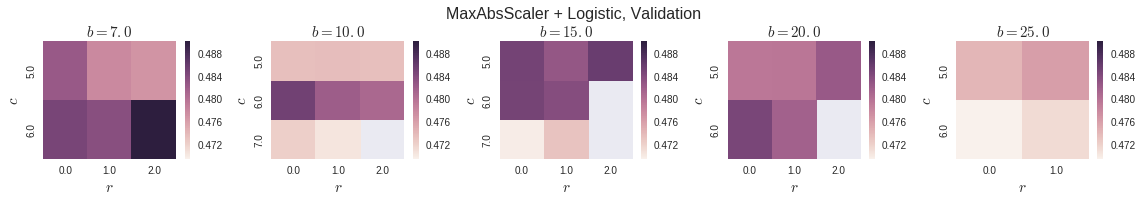

The best:
*allatom-s0-b7-c6-r2--residue_dependent--skip_errors.mat


RMSD    TM-score MaxSub-score GDT-TS-score  \
Mean rank of the native    64.6416     121.934      114.929      111.044   
Top 1                    0.0221239  0.00884956   0.00884956   0.00884956   
Top 5                     0.146018   0.0353982     0.039823    0.0486726   
Mean score for top 1       7.44039    0.548785     0.454958     0.490332   
Mean loss score            -4.8138    0.163819      0.15433     0.149845   
Mean Pearson              0.250976   -0.169545    -0.233198    -0.210022   
Mean Spearman             0.280924   -0.113765    -0.183488    -0.157968   

                        GDT-HA-score RMSD-backwards TM-score-backwards  \
Mean rank of the native      108.602        175.442            65.2257   
Top 1                      0.0132743              0          0.0176991   
Top 5                      0.0530973              0            0.10177   
Mean score for top 1        0.354587        7.44039           0.582765   
Mean loss score             0.121835        56.3947           0.171544   
Mean Pearson               -0.244896       0.250976          -0.306292   
Mean Spearman              -0.198071       0.280909          -0.295628   

                        MaxSub-score-backwards GDT-TS-score-backwards  \
Mean rank of the native                56.7566                56.0973   
Top 1                                0.0309735              0.0309735   
Top 5                                 0.150442               0.176991   
Mean score for top 1                  0.502572               0.546698   
Mean loss score                       0.230235               0.212151   
Mean Pearson                         -0.369205              -0.373742   
Mean Spearman                        -0.358854              -0.364546   

                        GDT-HA-score-backwards  
Mean rank of the native                57.2389  
Top 1                                 0.039823  
Top 5                                 0.176991  
Mean score for top 1                  0.397132  
Mean loss score                       0.206222  
Mean Pearson                         -0.387379  
Mean Spearman                         -0.37627

In [48]:
plot_results(results_val,
             'MaxAbsScaler + Logistic', mean_top1_score,
             params, info='Validation', num_cols=5)

##### Correlation score 

plot_results(results_val,
             'MaxAbsScaler + Logistic', correlation_score,
             params, info='Validation', num_cols=5, figsize=1)

### Regression

#### Row normalization

##### Mean score for top 1

plot_results(results_val,
             'Normalizer + Ridge', mean_top1_score,
             params, info='Validation', num_cols=5, figsize=1)

##### Correlation score 

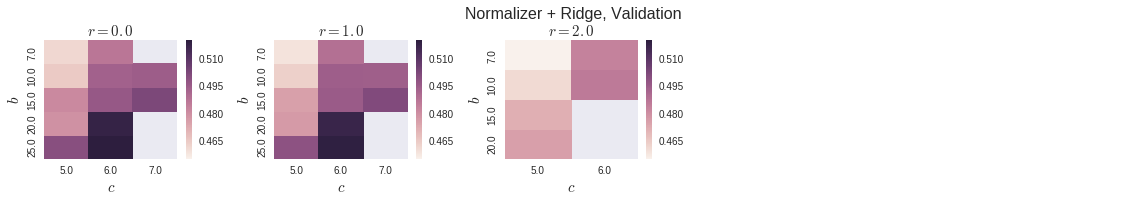

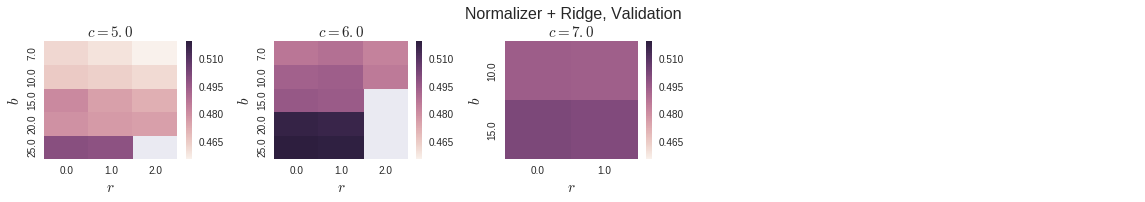

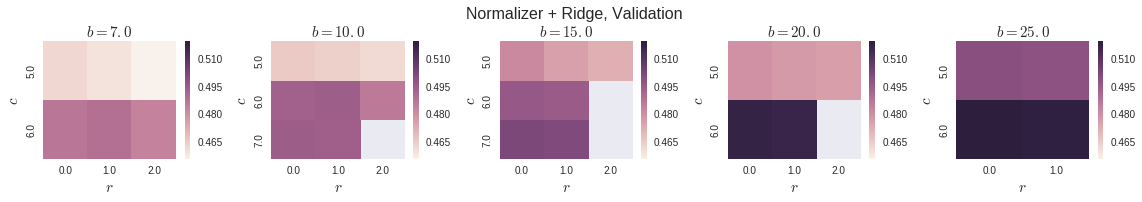

The best:
*allatom-s0-b25-c6-r0--residue_dependent--skip_errors.mat


RMSD   TM-score MaxSub-score GDT-TS-score  \
Mean rank of the native    101.181    83.4204      75.9513       76.177   
Top 1                    0.0265487  0.0132743    0.0132743   0.00884956   
Top 5                     0.132743  0.0486726    0.0619469    0.0530973   
Mean score for top 1       6.97473   0.570731     0.477461     0.508385   
Mean loss score           -4.34814   0.141874     0.131828     0.131792   
Mean Pearson              0.485799   -0.54467     -0.56725    -0.565388   
Mean Spearman             0.436027  -0.454671    -0.473683    -0.475094   
PMCC                      0.401404  -0.691752    -0.681335    -0.682042   
SMCC                      0.648564  -0.706258    -0.692922    -0.690001   
wmPMCC                    0.524347  -0.601513    -0.620235     -0.62145   
wmSMCC                    0.457085  -0.482436    -0.499647    -0.501945   
sum Z-score               -141.132    69.4667      95.2127      81.0393   

                        GDT-HA-score RMSD-backwards TM-score-backwards  \
Mean rank of the native      76.2301        238.487            75.9027   
Top 1                     0.00884956              0          0.0353982   
Top 5                      0.0486726              0           0.137168   
Mean score for top 1        0.369589        6.97473           0.612329   
Mean loss score             0.106833        56.8604            0.14198   
Mean Pearson               -0.570655       0.485799          -0.600194   
Mean Spearman              -0.479036       0.436019          -0.504251   
PMCC                       -0.665627       0.401404          -0.706251   
SMCC                       -0.681108       0.648563          -0.721749   
wmPMCC                     -0.623465       0.524347          -0.646366   
wmSMCC                     -0.505166       0.457089          -0.526637   
sum Z-score                  94.0359       -141.132            166.616   

                        MaxSub-score-backwards GDT-TS-score-backwards  \
Mean rank of the native                89.0398                83.5885   
Top 1                                0.0353982              0.0265487   
Top 5                                 0.141593               0.141593   
Mean score for top 1                   0.53518               0.572723   
Mean loss score                       0.197627               0.186127   
Mean Pearson                         -0.590018              -0.598401   
Mean Spearman                        -0.502567              -0.509688   
PMCC                                 -0.697128              -0.701982   
SMCC                                 -0.710701              -0.711408   
wmPMCC                               -0.637643              -0.646585   
wmSMCC                               -0.526008              -0.533033   
sum Z-score                            210.823                209.752   

                        GDT-HA-score-backwards  
Mean rank of the native                85.4513  
Top 1                                0.0265487  
Top 5                                 0.146018  
Mean score for top 1                  0.419933  
Mean loss score                       0.183421  
Mean Pearson                         -0.584923  
Mean Spearman                        -0.505597  
PMCC                                 -0.681478  
SMCC                                 -0.700763  
wmPMCC                               -0.633152  
wmSMCC                               -0.529592  
sum Z-score                            221.008

In [49]:
plot_results(results_val,
             'Normalizer + Ridge', correlation_score,
             params, info='Validation', num_cols=5)

#### Feature normalization

##### Mean score for top 1

plot_results(results_val,
             'MaxAbsScaler + Ridge', mean_top1_score,
             params, info='Validation', num_cols=5, figsize=1)

##### Correlation score 

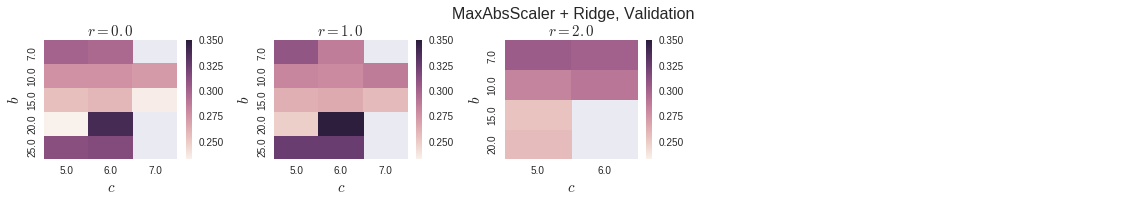

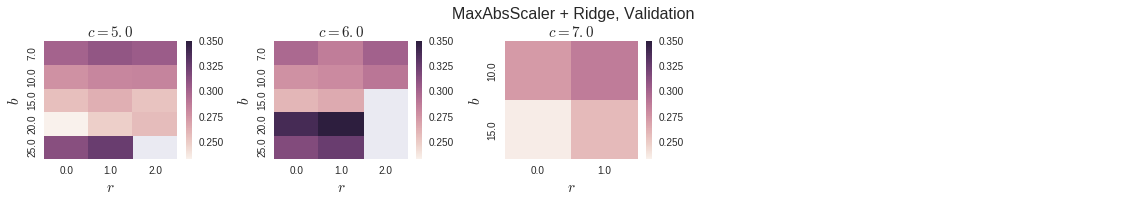

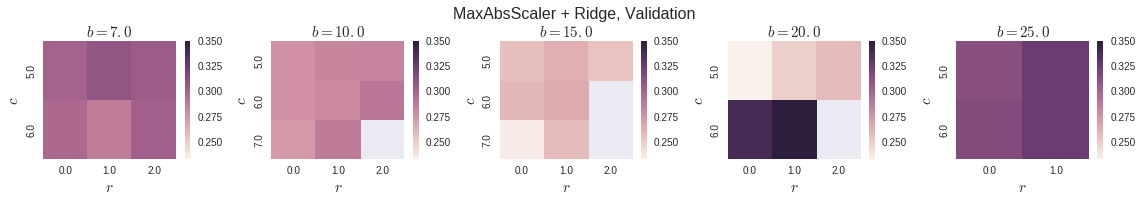

The best:
*allatom-s0-b20-c6-r1--residue_dependent--skip_errors.mat


RMSD    TM-score MaxSub-score GDT-TS-score  \
Mean rank of the native     107.102     97.1504      94.4956      94.5442   
Top 1                    0.00442478  0.00884956   0.00442478   0.00884956   
Top 5                     0.0176991   0.0530973    0.0619469     0.079646   
Mean score for top 1        9.54115     0.57991     0.470983     0.508294   
Mean loss score            -6.91455    0.132695     0.138306     0.131883   
Mean Pearson               0.304789   -0.356404    -0.379254    -0.375566   
Mean Spearman              0.291461   -0.310007    -0.326902    -0.325332   

                        GDT-HA-score RMSD-backwards TM-score-backwards  \
Mean rank of the native      94.7389        209.788             101.54   
Top 1                     0.00442478              0         0.00442478   
Top 5                      0.0619469     0.00442478          0.0309735   
Mean score for top 1        0.361332        9.54115           0.558029   
Mean loss score              0.11509        54.2939            0.19628   
Mean Pearson               -0.381509       0.304789          -0.383754   
Mean Spearman              -0.328604       0.291445          -0.329524   

                        MaxSub-score-backwards GDT-TS-score-backwards  \
Mean rank of the native                108.695                108.832   
Top 1                               0.00442478             0.00442478   
Top 5                                0.0176991              0.0221239   
Mean score for top 1                  0.449654               0.485281   
Mean loss score                       0.283152               0.273568   
Mean Pearson                         -0.385644              -0.389017   
Mean Spearman                        -0.338915               -0.33925   

                        GDT-HA-score-backwards  
Mean rank of the native                 109.35  
Top 1                               0.00442478  
Top 5                                0.0265487  
Mean score for top 1                  0.344732  
Mean loss score                       0.258622  
Mean Pearson                         -0.383816  
Mean Spearman                        -0.341192

In [50]:
plot_results(results_val,
             'MaxAbsScaler + Ridge', correlation_score,
             params, info='Validation', num_cols=5)

## Backup

In [9]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

### Save dump

In [52]:
if len(results_train) == 0:
    raise Exception('Empty results')
joblib.dump((results_train, results_val), theNotebook + '.pkl')

['benchmark_allatom_residue_dependent.pkl']

### Load from dump

In [10]:
results_train, results_val = joblib.load(theNotebook + '.pkl')